## Simulación

In [1]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
random.seed(42)

class MatchSimulationOLD:
    def __init__(self, home_team, away_team, home_players, away_players):
        self.home_team = home_team
        self.away_team = away_team
        self.home_players = home_players
        self.away_players = away_players
        
        self.match_duration = random.randint(100, 120) 
        
        self.base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))  
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))  
            
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.fliplr(np.flipud(matrix))

    def normalize_matrix(self, matrix, match_duration):
        """como estan en pases/errores/out/shot etc x minuto las pasamos a probabilidades"""
        total_shots = matrix * match_duration
        total_events = np.sum(total_shots)
        probability_matrix = total_shots / total_events
        return probability_matrix

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            # Si el archivo es un CSV, usamos np.loadtxt para cargarlo
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            # Si el archivo es un NPY, usamos np.load para cargarlo
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        
        return matrix


    def aggregate_team_matrices(self, team):
        """sumamos para el equipo"""

        if team == 'home':
            for player_name in self.home_players:
                self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(self.home_team, player_name, 'pass_transition_matrix')
                self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(self.home_team, player_name, 'pass_matrix')
                self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(self.home_team, player_name, 'shot_matrix')
                self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(self.home_team, player_name, 'defense_matrix')
                self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(self.home_team, player_name, 'goal_matrix')
                self.home_team_matrixes['error_matrix'] += self.load_player_matrix(self.home_team, player_name, 'errors_matrix')
                self.home_team_matrixes['out_matrix'] += self.load_player_matrix(self.home_team, player_name, 'out_matrix')  
        
        elif team == 'away':
            for player_name in self.away_players:
                self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(self.away_team, player_name, 'pass_transition_matrix')
                self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(self.away_team, player_name, 'pass_matrix')
                self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(self.away_team, player_name, 'shot_matrix')
                self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(self.away_team, player_name, 'defense_matrix')
                self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(self.away_team, player_name, 'goal_matrix')
                self.away_team_matrixes['error_matrix'] += self.load_player_matrix(self.away_team, player_name, 'errors_matrix')
                self.away_team_matrixes['out_matrix'] += self.load_player_matrix(self.away_team, player_name, 'out_matrix')  
        else:
            print(f'Error, {team} is not valid team!')

    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        self.aggregate_team_matrices('away')

    
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""

        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob, 
                                out_probability / total_prob]
            events = ['pass', 'interception', 'error', 'shot', 'out']
            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size

            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob, 
                                out_probability / total_prob]

            events = ['pass', 'interception', 'error', 'shot', 'out']
            selected_event = np.random.choice(events, p=normalized_probs)

        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8, 12)
        for _ in range(events_per_minute):
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                goal_scored = self.shoot_ball(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()

            elif current_event == 'out':
                self.change_possession()
                self.restart_from_sideline(current_position)

        self.mins_played += 1


    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]


    def shoot_ball(self, current_x, current_y):
        """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
        if self.current_team == 'home':
            goal_probability = self.home_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.away_team_matrixes['error_matrix'][current_x,current_y]
            shot_probability = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.away_team_matrixes['defense_matrix'][current_x, current_y]

            total_prob = goal_probability+ goal_added_probability + shot_probability + shot_added_probability
            normalized_probs = [(shot_probability+shot_added_probability) / total_prob, (goal_probability+goal_added_probability) / total_prob]

            events = ['failed shot', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)
            
            if selected_event == 'goal':
                return True
            else:
                return False
         
        if self.current_team == 'away':
            goal_probability = self.away_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.home_team_matrixes['error_matrix'][current_x,current_y]
            shot_probability = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.home_team_matrixes['defense_matrix'][current_x, current_y]

            total_prob = goal_probability+ goal_added_probability + shot_probability+shot_added_probability
            normalized_probs = [(shot_probability+shot_added_probability) / total_prob, (goal_probability+goal_added_probability) / total_prob]

            events = ['failed shot', 'goal']

            selected_event = np.random.choice(events, p=normalized_probs)

            if selected_event == 'goal':
                return True
            else:
                return False
        

    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

In [4]:
random.seed(42)

class MatchSimulation:
    def __init__(self, home_players_dict, away_players_dict,home_team = 'Custom Home Team', away_team='Custom Away Team'):
        self.home_team = home_team
        self.away_team = away_team

        self.home_players = home_players_dict
        self.away_players = away_players_dict
        
        self.match_duration = random.randint(100, 120) 
        
        self.base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))  
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))  
            
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.fliplr(np.flipud(matrix))

    def normalize_matrix(self, matrix, match_duration):
        """como estan en pases/errores/out/shot etc x minuto las pasamos a probabilidades"""
        total_shots = matrix * match_duration
        total_events = np.sum(total_shots)
        probability_matrix = total_shots / total_events
        return probability_matrix

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            # Si el archivo es un CSV, usamos np.loadtxt para cargarlo
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            # Si el archivo es un NPY, usamos np.load para cargarlo
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        
        return matrix


    def aggregate_team_matrices(self, team):
        """sumamos para el equipo"""

        if team == 'home':
            for team_name, players in self.home_players.items():
                for player_name, _ in players:  
                    self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.home_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.home_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  

        elif team == 'away':
            for team_name, players in self.away_players.items():
                for player_name, _ in players:  
                    self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.away_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.away_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  
        else:
            print(f'Error, {team} is not valid team!')

    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        self.aggregate_team_matrices('away')

    
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""

        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob, 
                                out_probability / total_prob]
            events = ['pass', 'interception', 'error', 'shot', 'out']
            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size

            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob, 
                                out_probability / total_prob]

            events = ['pass', 'interception', 'error', 'shot', 'out']
            selected_event = np.random.choice(events, p=normalized_probs)

        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8, 12)
        for _ in range(events_per_minute):
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                goal_scored = self.shoot_ball(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()

            elif current_event == 'out':
                self.change_possession()
                self.restart_from_sideline(current_position)

        self.mins_played += 1


    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]


    def shoot_ball(self, current_x, current_y):
        """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
        if self.current_team == 'home':
            goal_probability = self.home_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.away_team_matrixes['error_matrix'][current_x,current_y]
            shot_probability = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.away_team_matrixes['defense_matrix'][current_x, current_y]

            total_prob = goal_probability+ goal_added_probability + shot_probability + shot_added_probability
            normalized_probs = [(shot_probability+shot_added_probability) / total_prob, (goal_probability+goal_added_probability) / total_prob]

            events = ['failed shot', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)
            
            if selected_event == 'goal':
                return True
            else:
                return False
         
        if self.current_team == 'away':
            goal_probability = self.away_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.home_team_matrixes['error_matrix'][current_x,current_y]
            shot_probability = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.home_team_matrixes['defense_matrix'][current_x, current_y]

            total_prob = goal_probability+ goal_added_probability + shot_probability+shot_added_probability
            normalized_probs = [(shot_probability+shot_added_probability) / total_prob, (goal_probability+goal_added_probability) / total_prob]

            events = ['failed shot', 'goal']

            selected_event = np.random.choice(events, p=normalized_probs)

            if selected_event == 'goal':
                return True
            else:
                return False
        

    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [5]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [6]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [7]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1
    

            if 0 <= team_index < len(teams_list):
                team_name = teams_list[team_index]
                available_players = [player for player in players_data[team_name] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_name}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        # Cambiar de equipo
                        break
                    elif 0 <= player_index < len(available_players):
                        players_dict[team_name].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a tu equipo.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return players_dict

In [8]:
teams_list = ['Manchester United', 'Manchester City', 'Liverpool', 'Chelsea', 
                     'Tottenham Hotspur', 'Arsenal', 'Reading', 'Fulham', 'Everton']

In [9]:
players_dict = defaultdict(list)

for team in teams_list:
    players = get_team_players(team)
    if players:  
        players_dict[team] = players

In [104]:
home_players = choose_teams(teams_list, players_dict)
away_players = choose_teams(teams_list, players_dict)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Manchester United: ['van Persie, Robin', 'Evra, Patrice', 'Carrick, Michael', 'de Gea, David', 'Ferdinand, Rio', 'da Silva, Rafael Pereira', 'Valencia, Luis Antonio', 'Rooney, Wayne', 'Evans, Jonny', 'Vidic, Nemanja', 'Cleverley, Tom']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Chelsea: ['Cech, Petr', 'Ivanovic, Branislav', 'Cole, Ashley', 'Mata, Juan', 'Luiz Moreira Marinho, David', 'Torres, Fernando', 'Santos do Nascimento, Ramires

## Simulamos el partido

Simulamos partidos entre manchester united y chelsea, guardamos resultados y analizamos

In [10]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [106]:
random.seed(42)
df_results = simulate_matches(100, home_players, away_players)

Simulando partidos: 100%|██████████| 100/100 [00:09<00:00, 10.33partido/s]


In [107]:
home_players_change = choose_teams(teams_list, players_dict)
away_players_change = choose_teams(teams_list, players_dict)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Chelsea: ['Cech, Petr', 'Ivanovic, Branislav', 'Cole, Ashley', 'Mata, Juan', 'Luiz Moreira Marinho, David', 'Torres, Fernando', 'Santos do Nascimento, Ramires', 'Hazard, Eden', 'dos Santos Emboada Junior, Oscar', 'Cahill, Gary', 'Azpilicueta, Cesar']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton
Jugadores disponibles en Manchester United:
1. van Persie, Robin
2. Evra, Patrice
3. Carrick, Michael
4. de Gea, David
5. Ferdinand, Rio
6. da Silva, Rafael Pereira
7. Valencia,

In [108]:
random.seed(42)
df_results_change = simulate_matches(100, home_players_change, away_players_change)

Simulando partidos: 100%|██████████| 100/100 [00:10<00:00,  9.45partido/s]


In [95]:
df_results['resultado'] = df_results.apply(lambda row: 'local' if row['goles_local'] > row['goles_visitante'] else (
    'visitante' if row['goles_local'] < row['goles_visitante'] else 'empate'), axis=1)

# Contar resultados por equipo
results = {
    'equipo': [],
    'ganadas': [],
    'empatadas': [],
    'perdidas': []
}

# Contar para cada equipo
teams = set(df_results['home']).union(set(df_results['away']))
for team in teams:
    ganadas = len(df_results[(df_results['home'] == team) & (df_results['goles_local'] > df_results['goles_visitante'])]) + \
              len(df_results[(df_results['away'] == team) & (df_results['goles_visitante'] > df_results['goles_local'])])
    empatadas = len(df_results[(df_results['home'] == team) & (df_results['goles_local'] == df_results['goles_visitante'])]) + \
                len(df_results[(df_results['away'] == team) & (df_results['goles_visitante'] == df_results['goles_local'])])
    perdidas = len(df_results[(df_results['home'] == team) & (df_results['goles_local'] < df_results['goles_visitante'])]) + \
               len(df_results[(df_results['away'] == team) & (df_results['goles_visitante'] < df_results['goles_local'])])
    
    results['equipo'].append(team)
    results['ganadas'].append(ganadas)
    results['empatadas'].append(empatadas)
    results['perdidas'].append(perdidas)

# Crear DataFrame de resultados
df_results_final = pd.DataFrame(results)

# Mostrar resultados
print(df_results_final)

              equipo  ganadas  empatadas  perdidas
0            Chelsea       44         20        36
1  Manchester United       36         20        44


In [109]:
df_results_change['resultado'] = df_results_change.apply(lambda row: 'local' if row['goles_local'] > row['goles_visitante'] else (
    'visitante' if row['goles_local'] < row['goles_visitante'] else 'empate'), axis=1)

# Contar resultados por equipo
results_change = {
    'equipo': [],
    'ganadas': [],
    'empatadas': [],
    'perdidas': []
}

# Contar para cada equipo
teams = set(df_results_change['home']).union(set(df_results_change['away']))
for team in teams:
    ganadas = len(df_results_change[(df_results_change['home'] == team) & (df_results_change['goles_local'] > df_results_change['goles_visitante'])]) + \
              len(df_results_change[(df_results_change['away'] == team) & (df_results_change['goles_visitante'] > df_results_change['goles_local'])])
    empatadas = len(df_results_change[(df_results_change['home'] == team) & (df_results_change['goles_local'] == df_results_change['goles_visitante'])]) + \
                len(df_results_change[(df_results_change['away'] == team) & (df_results_change['goles_visitante'] == df_results_change['goles_local'])])
    perdidas = len(df_results_change[(df_results_change['home'] == team) & (df_results_change['goles_local'] < df_results['goles_visitante'])]) + \
               len(df_results_change[(df_results_change['away'] == team) & (df_results_change['goles_visitante'] < df_results_change['goles_local'])])
    
    results_change['equipo'].append(team)
    results_change['ganadas'].append(ganadas)
    results_change['empatadas'].append(empatadas)
    results_change['perdidas'].append(perdidas)

# Crear DataFrame de resultados
df_results_final_change = pd.DataFrame(results_change)

# Mostrar resultados
print(df_results_final_change)

              equipo  ganadas  empatadas  perdidas
0            Chelsea       40         23        39
1  Manchester United       37         23        40


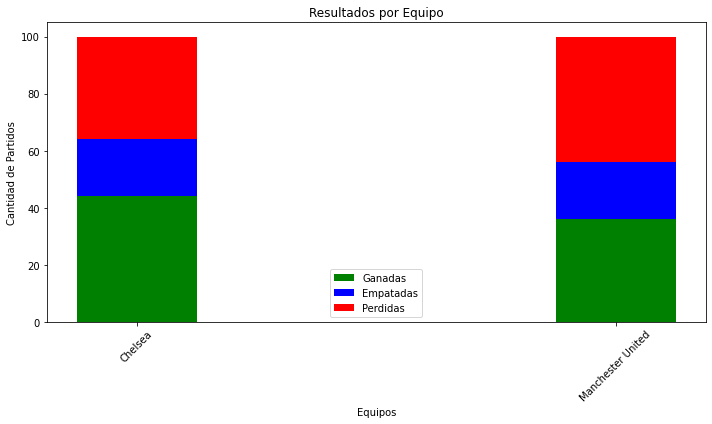

In [110]:
# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = range(len(df_results_final))

# Barras para partidos ganados, empatados y perdidos
ax.bar(index, df_results_final['ganadas'], bar_width, label='Ganadas', color='g')
ax.bar(index, df_results_final['empatadas'], bar_width, label='Empatadas', color='b', bottom=df_results_final['ganadas'])
ax.bar(index, df_results_final['perdidas'], bar_width, label='Perdidas', color='r', bottom=df_results_final['ganadas'] + df_results_final['empatadas'])

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad de Partidos')
ax.set_title('Resultados por Equipo')
ax.set_xticks(index)
ax.set_xticklabels(df_results_final['equipo'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


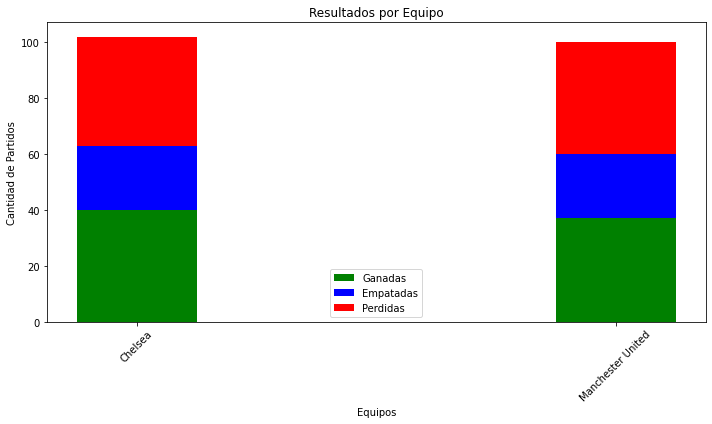

In [111]:
# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = range(len(df_results_final_change))

# Barras para partidos ganados, empatados y perdidos
ax.bar(index, df_results_final_change['ganadas'], bar_width, label='Ganadas', color='g')
ax.bar(index, df_results_final_change['empatadas'], bar_width, label='Empatadas', color='b', bottom=df_results_final_change['ganadas'])
ax.bar(index, df_results_final_change['perdidas'], bar_width, label='Perdidas', color='r', bottom=df_results_final_change['ganadas'] + df_results_final_change['empatadas'])

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad de Partidos')
ax.set_title('Resultados por Equipo')
ax.set_xticks(index)
ax.set_xticklabels(df_results_final_change['equipo'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

              equipo  goles  tiros  pases  quites
0            Chelsea    208    920  36485    6037
1  Manchester United    234    530  43726    6302


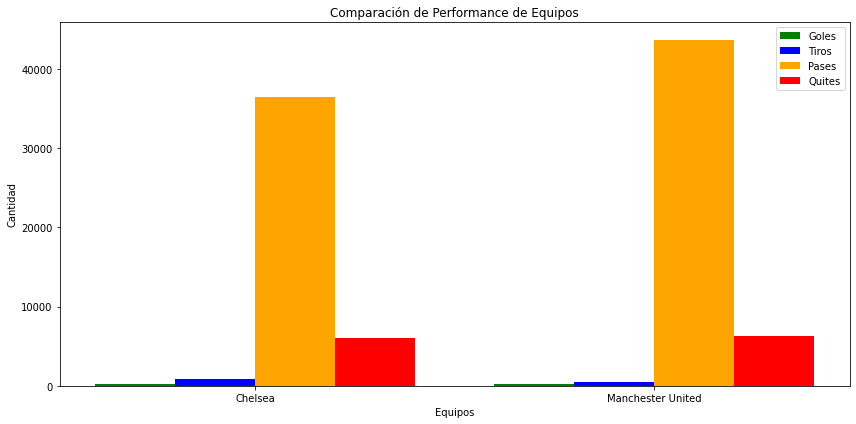

In [112]:
# Agrupar datos por equipo
teams = set(df_results['home']).union(set(df_results['away']))

# Inicializar diccionario para resultados
performance_data = {
    'equipo': [],
    'goles': [],
    'tiros': [],
    'pases': [],
    'quites': []
}

# Calcular métricas de rendimiento para cada equipo
for team in teams:
    goles = df_results[df_results['home'] == team]['goles_local'].sum() + \
            df_results[df_results['away'] == team]['goles_visitante'].sum()
    
    tiros = df_results[df_results['home'] == team]['tiros_local'].sum() + \
            df_results[df_results['away'] == team]['tiros_visitante'].sum()
    
    pases = df_results[df_results['home'] == team]['pases_local'].sum() + \
            df_results[df_results['away'] == team]['pases_visitante'].sum()
    
    quites = df_results[df_results['home'] == team]['quites_local'].sum() + \
             df_results[df_results['away'] == team]['quites_visitante'].sum()
    
    performance_data['equipo'].append(team)
    performance_data['goles'].append(goles)
    performance_data['tiros'].append(tiros)
    performance_data['pases'].append(pases)
    performance_data['quites'].append(quites)

# Crear DataFrame de rendimiento
df_performance = pd.DataFrame(performance_data)

# Mostrar DataFrame de rendimiento
print(df_performance)

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(df_performance))

# Barras para cada métrica
ax.bar(index, df_performance['goles'], bar_width, label='Goles', color='g')
ax.bar([i + bar_width for i in index], df_performance['tiros'], bar_width, label='Tiros', color='b')
ax.bar([i + 2 * bar_width for i in index], df_performance['pases'], bar_width, label='Pases', color='orange')
ax.bar([i + 3 * bar_width for i in index], df_performance['quites'], bar_width, label='Quites', color='r')

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad')
ax.set_title('Comparación de Performance de Equipos')
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df_performance['equipo'])
ax.legend()

plt.tight_layout()
plt.show()

              equipo  goles  tiros  pases  quites
0            Chelsea    242    984  36502    5696
1  Manchester United    234    630  44804    5845


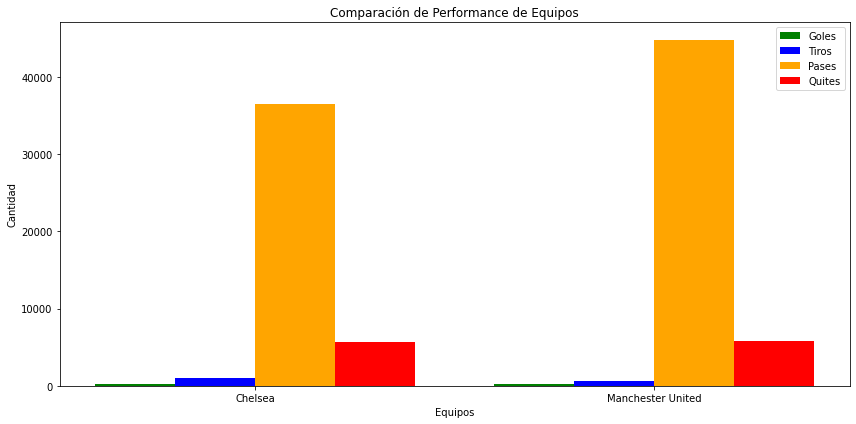

In [113]:
# Agrupar datos por equipo
teams = set(df_results_change['home']).union(set(df_results_change['away']))

# Inicializar diccionario para resultados
performance_data = {
    'equipo': [],
    'goles': [],
    'tiros': [],
    'pases': [],
    'quites': []
}

# Calcular métricas de rendimiento para cada equipo
for team in teams:
    goles = df_results_change[df_results_change['home'] == team]['goles_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['goles_visitante'].sum()
    
    tiros = df_results_change[df_results_change['home'] == team]['tiros_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['tiros_visitante'].sum()
    
    pases = df_results_change[df_results_change['home'] == team]['pases_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['pases_visitante'].sum()
    
    quites = df_results_change[df_results_change['home'] == team]['quites_local'].sum() + \
             df_results_change[df_results_change['away'] == team]['quites_visitante'].sum()
    
    performance_data['equipo'].append(team)
    performance_data['goles'].append(goles)
    performance_data['tiros'].append(tiros)
    performance_data['pases'].append(pases)
    performance_data['quites'].append(quites)

# Crear DataFrame de rendimiento
df_performance_change = pd.DataFrame(performance_data)

# Mostrar DataFrame de rendimiento
print(df_performance_change)

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(df_performance_change))

# Barras para cada métrica
ax.bar(index, df_performance_change['goles'], bar_width, label='Goles', color='g')
ax.bar([i + bar_width for i in index], df_performance_change['tiros'], bar_width, label='Tiros', color='b')
ax.bar([i + 2 * bar_width for i in index], df_performance_change['pases'], bar_width, label='Pases', color='orange')
ax.bar([i + 3 * bar_width for i in index], df_performance_change['quites'], bar_width, label='Quites', color='r')

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad')
ax.set_title('Comparación de Performance de Equipos')
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df_performance_change['equipo'])
ax.legend()

plt.tight_layout()
plt.show()

              equipo  goles_por_tiro  quites_por_pase_rival
0            Chelsea        0.226087               0.165465
1  Manchester United        0.441509               0.144125


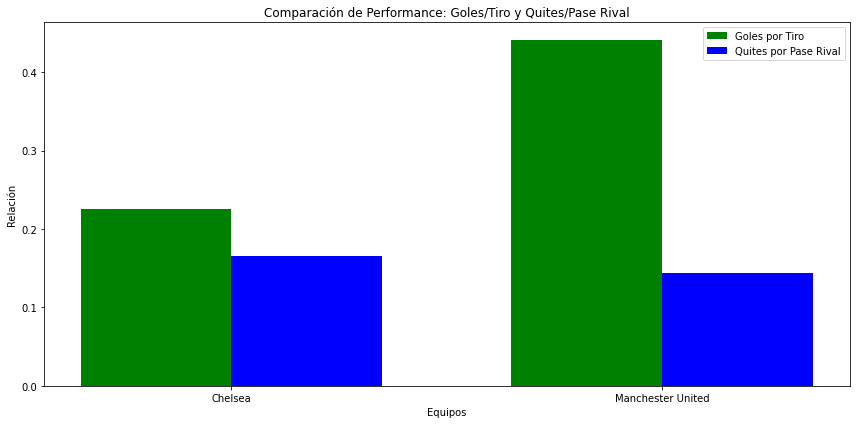

In [114]:
# Agrupar datos por equipo
teams = set(df_results['home']).union(set(df_results['away']))

# Inicializar diccionario para resultados
performance_data = {
    'equipo': [],
    'goles_por_tiro': [],
    'quites_por_pase_rival': []
}

# Calcular métricas de rendimiento para cada equipo
for team in teams:
    # Calcular goles y tiros
    goles = df_results[df_results['home'] == team]['goles_local'].sum() + \
            df_results[df_results['away'] == team]['goles_visitante'].sum()
    
    tiros = df_results[df_results['home'] == team]['tiros_local'].sum() + \
            df_results[df_results['away'] == team]['tiros_visitante'].sum()

    # Calcular quites y pases rivales
    quites = df_results[df_results['home'] == team]['quites_local'].sum() + \
             df_results[df_results['away'] == team]['quites_visitante'].sum()
    
    pases = df_results[df_results['home'] == team]['pases_local'].sum() + \
            df_results[df_results['away'] == team]['pases_visitante'].sum()

    # Evitar división por cero
    goles_por_tiro = goles / tiros if tiros > 0 else 0
    quites_por_pase_rival = quites / pases if pases > 0 else 0
    
    performance_data['equipo'].append(team)
    performance_data['goles_por_tiro'].append(goles_por_tiro)
    performance_data['quites_por_pase_rival'].append(quites_por_pase_rival)

# Crear DataFrame de rendimiento
df_performance = pd.DataFrame(performance_data)

# Mostrar DataFrame de rendimiento
print(df_performance)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(df_performance))

# Barras para cada métrica
ax.bar(index, df_performance['goles_por_tiro'], bar_width, label='Goles por Tiro', color='g')
ax.bar([i + bar_width for i in index], df_performance['quites_por_pase_rival'], bar_width, label='Quites por Pase Rival', color='b')

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Relación')
ax.set_title('Comparación de Performance: Goles/Tiro y Quites/Pase Rival')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df_performance['equipo'])
ax.legend()

plt.tight_layout()
plt.show()

              equipo  goles_por_tiro  quites_por_pase_rival
0            Chelsea        0.245935               0.156046
1  Manchester United        0.371429               0.130457


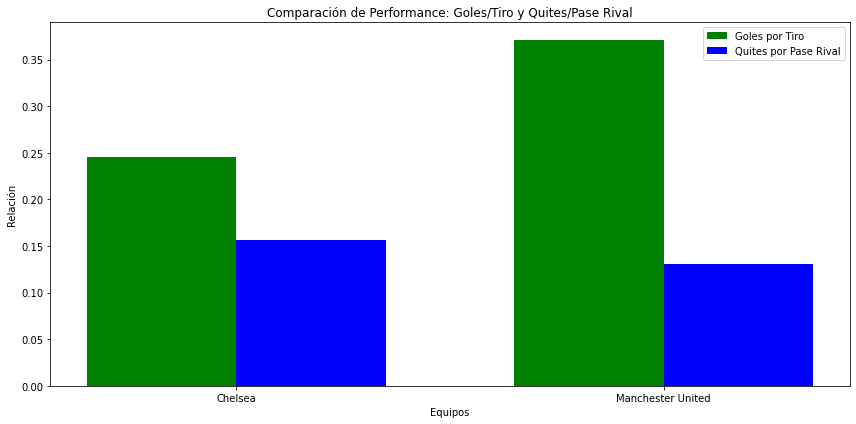

In [115]:
# Agrupar datos por equipo
teams = set(df_results['home']).union(set(df_results['away']))

# Inicializar diccionario para resultados
performance_data_change = {
    'equipo': [],
    'goles_por_tiro': [],
    'quites_por_pase_rival': []
}

# Calcular métricas de rendimiento para cada equipo
for team in teams:
    # Calcular goles y tiros
    goles = df_results_change[df_results_change['home'] == team]['goles_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['goles_visitante'].sum()
    
    tiros = df_results_change[df_results_change['home'] == team]['tiros_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['tiros_visitante'].sum()

    # Calcular quites y pases rivales
    quites = df_results_change[df_results_change['home'] == team]['quites_local'].sum() + \
             df_results_change[df_results_change['away'] == team]['quites_visitante'].sum()
    
    pases = df_results_change[df_results_change['home'] == team]['pases_local'].sum() + \
            df_results_change[df_results_change['away'] == team]['pases_visitante'].sum()

    # Evitar división por cero
    goles_por_tiro = goles / tiros if tiros > 0 else 0
    quites_por_pase_rival = quites / pases if pases > 0 else 0
    
    performance_data_change['equipo'].append(team)
    performance_data_change['goles_por_tiro'].append(goles_por_tiro)
    performance_data_change['quites_por_pase_rival'].append(quites_por_pase_rival)

# Crear DataFrame de rendimiento
df_performance_change = pd.DataFrame(performance_data_change)

# Mostrar DataFrame de rendimiento
print(df_performance_change)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(df_performance_change))

# Barras para cada métrica
ax.bar(index, df_performance_change['goles_por_tiro'], bar_width, label='Goles por Tiro', color='g')
ax.bar([i + bar_width for i in index], df_performance_change['quites_por_pase_rival'], bar_width, label='Quites por Pase Rival', color='b')

# Añadir etiquetas y título
ax.set_xlabel('Equipos')
ax.set_ylabel('Relación')
ax.set_title('Comparación de Performance: Goles/Tiro y Quites/Pase Rival')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df_performance_change['equipo'])
ax.legend()

plt.tight_layout()
plt.show()

## Graficos

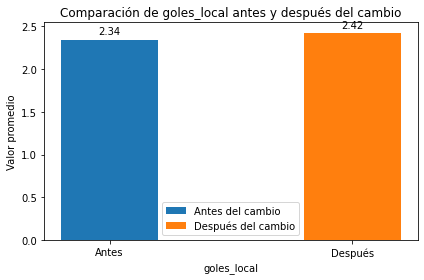

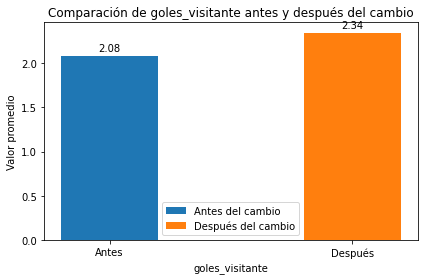

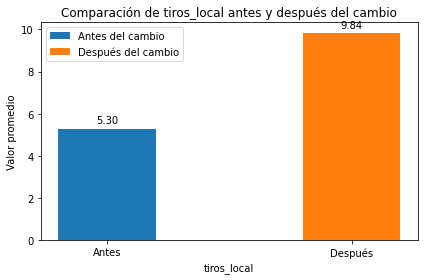

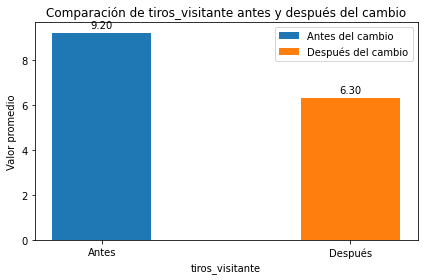

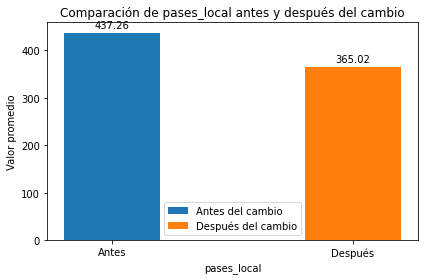

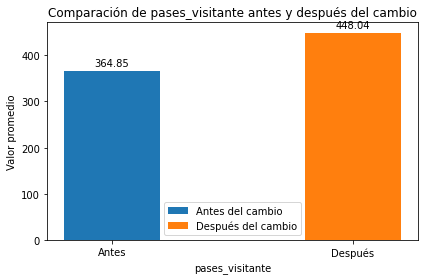

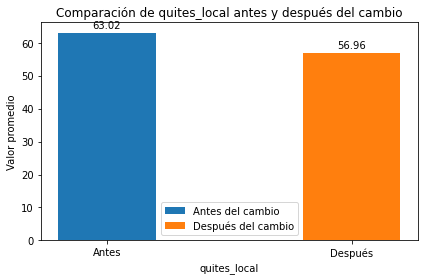

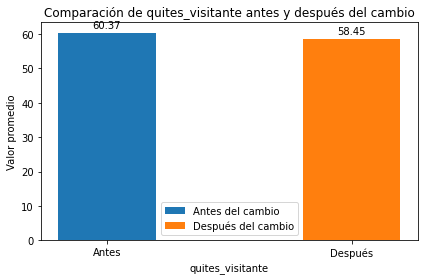

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que df_results y df_results_change ya están definidos

# Listamos todas las columnas que queremos analizar
columns_to_plot = [col for col in df_results.columns if col not in ['home', 'away']]

# Iterar sobre cada columna y crear un gráfico individual
for col in columns_to_plot:
    averages_before = df_results[col].mean()
    averages_after = df_results_change[col].mean()
    
    fig, ax = plt.subplots(figsize=(6, 4))  # Tamaño del gráfico
    
    # Configuración de las barras
    x = np.arange(2)
    width = 0.4
    
    bars1 = ax.bar(x[0], averages_before, width, label='Antes del cambio')
    bars2 = ax.bar(x[1], averages_after, width, label='Después del cambio')
    
    # Etiquetas y leyenda
    ax.set_xlabel(col)
    ax.set_ylabel('Valor promedio')
    ax.set_title(f'Comparación de {col} antes y después del cambio')
    ax.set_xticks(x)
    ax.set_xticklabels(['Antes', 'Después'])
    ax.legend()
    
    # Añadir valores en las barras para mejor interpretación
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento del texto
                    textcoords='offset points',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

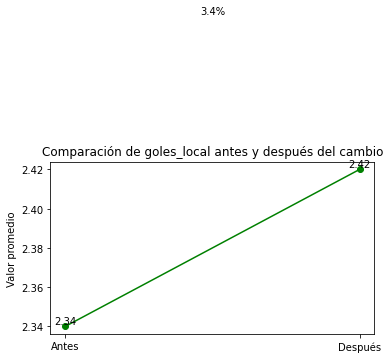

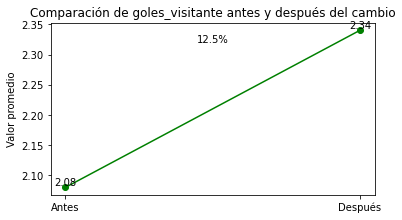

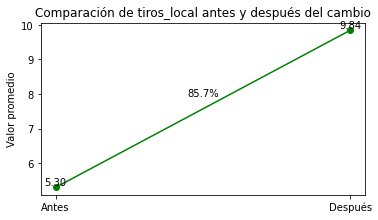

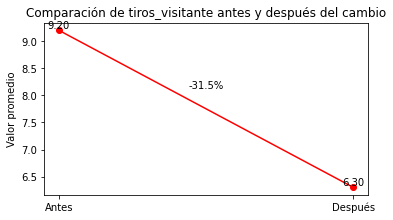

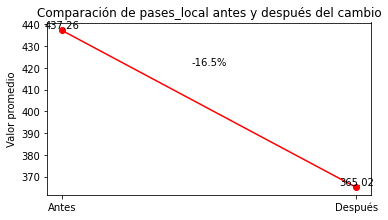

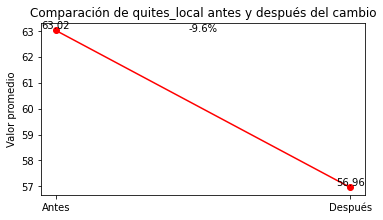

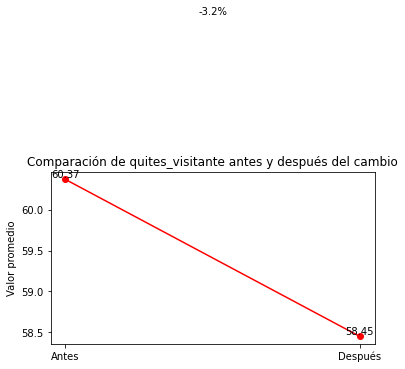

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de las categorías
categorias = ['goles_local', 'goles_visitante', 'tiros_local', 
              'tiros_visitante', 'pases_local', 'quites_local', 'quites_visitante']

# Iterar sobre cada categoría y crear un gráfico individual
for col in categorias:
    antes = df_results[col].mean()
    despues = df_results_change[col].mean()

    # Calcular el cambio porcentual
    cambio_porcentual = (despues - antes) / antes * 100

    # Configuración del gráfico
    fig, ax = plt.subplots(figsize=(6, 4))

    # Configuración de los puntos
    x = [0, 1]  # Dos puntos para "Antes" y "Después"
    y = [antes, despues]

    ax.plot(x, y, marker='o', linestyle='-', color='red' if cambio_porcentual < 0 else 'green')

    # Añadir etiquetas de valores
    ax.text(x[0], y[0], f'{antes:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(x[1], y[1], f'{despues:.2f}', ha='center', va='bottom', fontsize=10)

    # Calcular la posición media para la etiqueta del porcentaje
    x_mid = (x[0] + x[1]) / 2
    y_mid = (y[0] + y[1]) / 2

    # Colocar la etiqueta del porcentaje ligeramente por encima del punto medio de la línea
    ax.text(x_mid, y_mid + abs(y_mid) * 0.05, f'{cambio_porcentual:.1f}%', ha='center', color='black', fontsize=10)

    # Configuración de las etiquetas y título
    ax.set_xticks(x)
    ax.set_xticklabels(['Antes', 'Después'])
    ax.set_ylabel('Valor promedio', fontsize=10)
    ax.set_title(f'Comparación de {col} antes y después del cambio', fontsize=12)

    # Ajustar manualmente los márgenes del gráfico
    plt.subplots_adjust(left=0.15, right=0.9, top=0.85, bottom=0.25)

    # Mostrar el gráfico
    plt.show()


In [119]:
df_results

,home,away,goles_local,goles_visitante,tiros_local,tiros_visitante,pases_local,pases_visitante,quites_local,quites_visitante
0,Manchester United,Chelsea,2,2,8,10,462,376,66,64
1,Manchester United,Chelsea,3,2,9,12,444,385,54,57
2,Manchester United,Chelsea,2,4,4,9,416,322,63,67
3,Manchester United,Chelsea,1,1,2,2,407,405,62,74
4,Manchester United,Chelsea,4,1,6,6,434,370,63,59
...,...,...,...,...,...,...,...,...,...,...
95,Manchester United,Chelsea,2,3,2,6,498,366,53,61
96,Manchester United,Chelsea,1,2,3,12,386,347,53,58
97,Manchester United,Chelsea,4,1,7,12,446,346,58,59
98,Manchester United,Chelsea,2,2,4,8,450,320,61,60


In [11]:
def simulate_and_compare(teams_list, players_dict, num_matches=10000):
    # Simulate the first set of matches
    home_players = choose_teams(teams_list, players_dict)
    away_players = choose_teams(teams_list, players_dict)
    
    df_results = simulate_matches(num_matches, home_players, away_players)

    # Simulate the changed set of matches
    home_players_change = choose_teams(teams_list, players_dict)
    away_players_change = choose_teams(teams_list, players_dict)
    
    df_results_change = simulate_matches(num_matches, home_players_change, away_players_change)

    home_players_names = [player[0] for team, players in home_players.items() for player in players]
    away_players_names = [player[0] for team, players in away_players.items() for player in players]
    home_players_change_names = [player[0] for team, players in home_players_change.items() for player in players]
    away_players_change_names = [player[0] for team, players in away_players_change.items() for player in players]

    # Prepare the summary data
    summary_data = {
        'home_players': home_players_names,
        'away_players': away_players_names,
        'home_players_change': home_players_change_names,
        'away_players_change': away_players_change_names,
    }
    
    # Calculate player differences
    summary_data['home_player_diff'] = list(set(home_players_names) - set(home_players_change_names))
    summary_data['away_player_diff'] = list(set(away_players_names) - set(away_players_change_names))

    # Calculate total goals, shots, interceptions, etc.
    home_goals = df_results['goles_local'].mean()
    away_goals = df_results['goles_visitante'].mean()
    
    home_goals_change = df_results_change['goles_local'].mean()
    away_goals_change = df_results_change['goles_visitante'].mean()

    summary_data.update({
        'home_goals': home_goals,
        'away_goals': away_goals,
        'home_goals_change': home_goals_change,
        'away_goals_change': away_goals_change,
        'home_goals_%_change': ((home_goals_change - home_goals) / home_goals) * 100 if home_goals != 0 else None,
        'away_goals_%_change': ((away_goals_change - away_goals) / away_goals) * 100 if away_goals != 0 else None,
    })

    home_shots = df_results['tiros_local'].mean()
    away_shots = df_results['tiros_visitante'].mean()
    
    home_shots_change = df_results_change['tiros_local'].mean()
    away_shots_change = df_results_change['tiros_visitante'].mean()

    summary_data.update({
        'home_shots': home_shots,
        'away_shots': away_shots,
        'home_shots_change': home_shots_change,
        'away_shots_change': away_shots_change,
        'home_shots_%_change': ((home_shots_change - home_shots) / home_shots) * 100 if home_shots != 0 else None,
        'away_shots_%_change': ((away_shots_change - away_shots) / away_shots) * 100 if away_shots != 0 else None,
    })

    # Calculate interceptions
    home_interceptions = df_results['quites_local'].mean()
    away_interceptions = df_results['quites_visitante'].mean()
    
    home_interceptions_change = df_results_change['quites_local'].mean()
    away_interceptions_change = df_results_change['quites_visitante'].mean()

    summary_data.update({
        'home_interceptions': home_interceptions,
        'away_interceptions': away_interceptions,
        'home_interceptions_change': home_interceptions_change,
        'away_interceptions_change': away_interceptions_change,
        'home_interceptions_%_change': ((home_interceptions_change - home_interceptions) / home_interceptions) * 100 if home_interceptions != 0 else None,
        'away_interceptions_%_change': ((away_interceptions_change - away_interceptions) / away_interceptions) * 100 if away_interceptions != 0 else None,
    })

    # Calculate rival passes
    home_passes = df_results['pases_visitante'].mean()
    away_passes = df_results['pases_local'].mean()
    
    home_passes_change = df_results_change['pases_visitante'].mean()
    away_passes_change = df_results_change['pases_local'].mean()

    summary_data.update({
        'home_passes': home_passes,
        'away_passes': away_passes,
        'home_passes_rival_%_change': ((home_passes_change - home_passes) / home_passes) * 100 if home_passes != 0 else None,
        'away_passes_rival_%_change': ((away_passes_change - away_passes) / away_passes) * 100 if away_passes != 0 else None,
    })

    # Calculate goals/shots ratio
    home_goals_per_shot = df_results['goles_local'].sum() / df_results['tiros_local'].sum() if home_shots > 0 else None
    away_goals_per_shot = df_results['goles_visitante'].sum() / df_results['tiros_visitante'].sum() if home_shots > 0 else None
    
    home_goals_per_shot_change = home_goals_change / home_shots_change if home_shots_change > 0 else None
    away_goals_per_shot_change = away_goals_change / away_shots_change if away_shots_change > 0 else None

    summary_data.update({
        'home_goals_per_shot': home_goals_per_shot,
        'away_goals_per_shot': away_goals_per_shot,
        'home_goals_per_shot_change': home_goals_per_shot_change,
        'away_goals_per_shot_change': away_goals_per_shot_change,
    })

    # Convert summary_data to DataFrame
    summary_df = pd.DataFrame([summary_data])
    return summary_df

# Example usage
summary_results_df = simulate_and_compare(teams_list, players_dict)
print(summary_results_df)


¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Chelsea: ['Cech, Petr', 'Ivanovic, Branislav', 'Cole, Ashley', 'Mata, Juan', 'Luiz Moreira Marinho, David', 'Torres, Fernando', 'Santos do Nascimento, Ramires', 'Hazard, Eden', 'dos Santos Emboada Junior, Oscar', 'Cahill, Gary', 'Azpilicueta, Cesar']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Manchester United: ['van Persie, Robin', 'Evra, Patrice', 'Carrick, Michael', 'de Gea, David', 'Ferdinand, Rio', 'da Silva, Rafael Pereira', 'V

Simulando partidos: 100%|██████████| 10000/10000 [21:46<00:00,  7.66partido/s]


¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Chelsea: ['Cech, Petr', 'Ivanovic, Branislav', 'Cole, Ashley', 'Mata, Juan', 'Luiz Moreira Marinho, David', 'Torres, Fernando', 'Santos do Nascimento, Ramires', 'Hazard, Eden', 'dos Santos Emboada Junior, Oscar', 'Cahill, Gary', 'Azpilicueta, Cesar']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton
Jugadores disponibles en Manchester United:
1. van Persie, Robin
2. Evra, Patrice
3. Carrick, Michael
4. de Gea, David
5. Ferdinand, Rio
6. da Silva, Rafael Pereira
7. Valencia,

Simulando partidos: 100%|██████████| 10000/10000 [21:46<00:00,  7.65partido/s]

                                        home_players  \
0  [Cech, Petr, Ivanovic, Branislav, Cole, Ashley...   

                                        away_players  \
0  [van Persie, Robin, Evra, Patrice, Carrick, Mi...   

                                 home_players_change  \
0  [Cech, Petr, Ivanovic, Branislav, Cole, Ashley...   

                                 away_players_change home_player_diff  \
0  [Evra, Patrice, Carrick, Michael, de Gea, Davi...               []   

      away_player_diff  home_goals  away_goals  home_goals_change  \
0  [van Persie, Robin]      2.2109      2.0514             1.8479   

   away_goals_change  ...  home_interceptions_%_change  \
0             1.4533  ...                    -2.773269   

   away_interceptions_%_change  home_passes  away_passes  \
0                    -2.952586     433.6933     362.3477   

   home_passes_rival_%_change  away_passes_rival_%_change  \
0                    4.742637                   -2.626069   

   home_goals_

In [15]:
summary_results_df.columns

Index(['home_players', 'away_players', 'home_players_change',
       'away_players_change', 'home_player_diff', 'away_player_diff',
       'home_goals', 'away_goals', 'home_goals_change', 'away_goals_change',
       'home_goals_%_change', 'away_goals_%_change', 'home_shots',
       'away_shots', 'home_shots_change', 'away_shots_change',
       'home_shots_%_change', 'away_shots_%_change', 'home_interceptions',
       'away_interceptions', 'home_interceptions_change',
       'away_interceptions_change', 'home_interceptions_%_change',
       'away_interceptions_%_change', 'home_passes', 'away_passes',
       'home_passes_rival_%_change', 'away_passes_rival_%_change',
       'home_goals_per_shot', 'away_goals_per_shot',
       'home_goals_per_shot_change', 'away_goals_per_shot_change'],
      dtype='object')

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_1184/1057341271.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


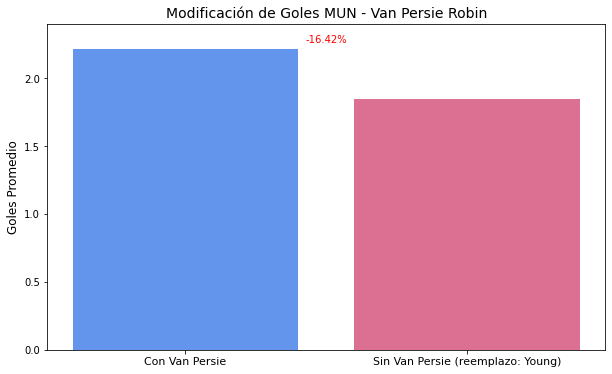

In [39]:
import matplotlib.pyplot as plt

# Nombres de las columnas a usar
columnas = ['home_goals', 'home_goals_change']
porcentaje_cambio = 'home_goals_%_change'

# Crear la figura y el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras con los colores personalizados
bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# Calcular la posición central entre las dos barras
center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

# Añadir el comentario del porcentaje una sola vez, en el medio de las dos barras
ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
            xy=(center_position, max([bar.get_height() for bar in bars])),
            xytext=(0, 5),  # Ajuste de desplazamiento
            textcoords='offset points',
            ha='center', va='bottom', color='red')

# Renombrar los ejes
ax.set_ylabel('Goles Promedio', fontsize=12)
ax.set_ylim(0.0,2.4)

# Renombrar las etiquetas de las barras (eje X)
nuevas_etiquetas = ['Con Van Persie', 'Sin Van Persie (reemplazo: Young)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# Título del gráfico
ax.set_title('Modificación de Goles MUN - Van Persie Robin', fontsize=14)

# Mostrar el gráfico
plt.show()

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_1184/552459015.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


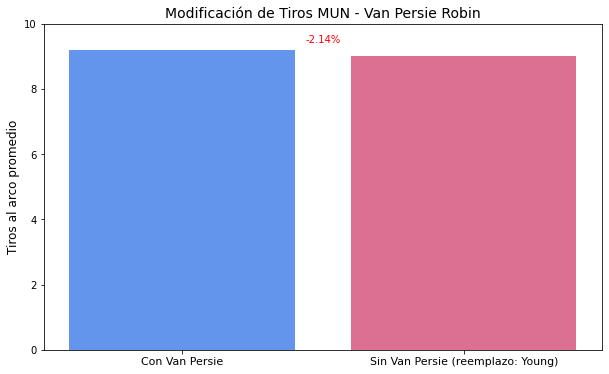

In [29]:

# Nombres de las columnas a usar
columnas = ['home_shots', 'home_shots_change']
porcentaje_cambio = 'home_shots_%_change'

# Crear la figura y el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras con los colores personalizados
bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# Calcular la posición central entre las dos barras
center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

# Añadir el comentario del porcentaje una sola vez, en el medio de las dos barras
ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
            xy=(center_position, max([bar.get_height() for bar in bars])),
            xytext=(0, 5),  # Ajuste de desplazamiento
            textcoords='offset points',
            ha='center', va='bottom', color='red')

# Renombrar los ejes
ax.set_ylabel('Tiros al arco promedio', fontsize=12)
ax.set_ylim(0,10)

# Renombrar las etiquetas de las barras (eje X)
nuevas_etiquetas = ['Con Van Persie', 'Sin Van Persie (reemplazo: Young)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# Título del gráfico
ax.set_title('Modificación de Tiros MUN - Van Persie Robin', fontsize=14)

# Mostrar el gráfico
plt.show()

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_1184/2908677506.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


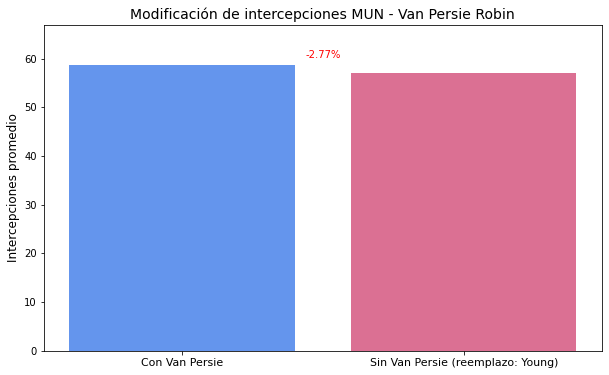

In [37]:
columnas = ['home_interceptions', 'home_interceptions_change']
porcentaje_cambio = 'home_interceptions_%_change'

# Crear la figura y el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras con los colores personalizados
bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# Calcular la posición central entre las dos barras
center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

# Añadir el comentario del porcentaje una sola vez, en el medio de las dos barras
ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
            xy=(center_position, max([bar.get_height() for bar in bars])),
            xytext=(0, 5),  # Ajuste de desplazamiento
            textcoords='offset points',
            ha='center', va='bottom', color='red')

# Renombrar los ejes
ax.set_ylabel('Intercepciones promedio', fontsize=12)
ax.set_ylim(0,67)

# Renombrar las etiquetas de las barras (eje X)
nuevas_etiquetas = ['Con Van Persie', 'Sin Van Persie (reemplazo: Young)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# Título del gráfico
ax.set_title('Modificación de intercepciones MUN - Van Persie Robin', fontsize=14)

# Mostrar el gráfico
plt.show()

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_1184/2567265971.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


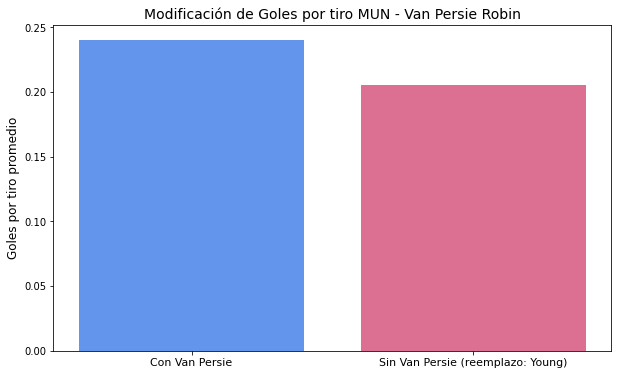

In [33]:
columnas = ['home_goals_per_shot', 'home_goals_per_shot_change']

# Crear la figura y el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras con los colores personalizados
bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# Renombrar los ejes
ax.set_ylabel('Goles por tiro promedio', fontsize=12)
# ax.set_ylim(0,10)

# Renombrar las etiquetas de las barras (eje X)
nuevas_etiquetas = ['Con Van Persie', 'Sin Van Persie (reemplazo: Young)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# Título del gráfico
ax.set_title('Modificación de Goles por tiro MUN - Van Persie Robin', fontsize=14)

# Mostrar el gráfico
plt.show()

## Patrice Evra

In [ ]:
evra_df_analysis = simulate_and_compare(teams_list, players_dict)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Chelsea: ['Cech, Petr', 'Ivanovic, Branislav', 'Cole, Ashley', 'Mata, Juan', 'Luiz Moreira Marinho, David', 'Torres, Fernando', 'Santos do Nascimento, Ramires', 'Hazard, Eden', 'dos Santos Emboada Junior, Oscar', 'Cahill, Gary', 'Azpilicueta, Cesar']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Liverpool
4. Chelsea
5. Tottenham Hotspur
6. Arsenal
7. Reading
8. Fulham
9. Everton

Equipo titular seleccionado para Manchester United: ['van Persie, Robin', 'Evra, Patrice', 'Carrick, Michael', 'de Gea, David', 'Ferdinand, Rio', 'da Silva, Rafael Pereira', 'V

Simulando partidos:  42%|████▏     | 4200/10000 [09:25<13:08,  7.35partido/s]